In [1]:
from __future__ import absolute_import, division, print_function
#%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' #for plotting. Do not know why 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import torch.nn.functional as F
import FSLNet
import cv2
#from utils import download_model_if_doesnt_exist
from einops import rearrange, repeat

In [2]:

@torch.no_grad()
def predict(img):
    return model_depth(img)['disp', 0]

def disp_to_depth(disp, min_depth=0.1, max_depth=100.0):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return depth
def normalize_depth_for_display(depth, pc=95, crop_percent=0, normalizer=None,cmap='plasma'):
    """Converts a depth map to an RGB image."""
    # Convert to disparity.
    disp = 1.0 / (depth + 1e-6)
    if normalizer is not None:
        disp /= normalizer
    else:
        disp /= (np.percentile(disp, pc) + 1e-6)
    disp = np.clip(disp, 0, 1)
    disp = gray2rgb(disp, cmap=cmap)
    keep_h = int(disp.shape[0] * (1 - crop_percent))
    disp = disp[:keep_h]
    return disp

def gray2rgb(im, cmap='plasma'):
    cmap = plt.get_cmap(cmap)
    result_img = cmap(im.astype(np.float32))
    if result_img.shape[2] > 3:
        result_img = np.delete(result_img, 3, 2)
    return result_img

In [3]:
model = 'L'

if model == 'L':
    model_depth = FSLNet.JointDepthNet(model='L').cuda()
    model_path = './weights/FSLNet-L/depth.pth'
    model_depth.load_state_dict(torch.load(model_path))
if model == 'S':
    model_depth = FSLNet.JointDepthNet(model='S').cuda()
    model_path = './weights/FSLNet-S/depth.pth'
    model_depth.load_state_dict(torch.load(model_path))
model_depth.eval();

(-0.5, 415.5, 127.5, -0.5)

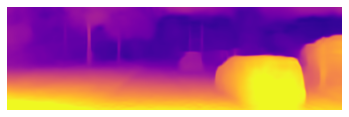

In [4]:
tgt_img = pil.open('./test.jpg').convert('RGB')
tgt_img = transforms.ToTensor()(tgt_img).unsqueeze(0)
pred_disp = predict(tgt_img.cuda())
pred_depth = disp_to_depth(pred_disp)[0,0]
pred_depth = pred_depth.cpu().numpy()
plt.imshow(normalize_depth_for_display(pred_depth))
plt.axis('off')